<a href="https://colab.research.google.com/github/DSE-Group7/5g-energy-consumption-modeling/blob/main/Notebooks/Samith/samith_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pcp_df = pd.read_csv("/content/drive/MyDrive/competitions/input/power_consumption_prediction.csv")
cl_df = pd.read_csv("/content/drive/MyDrive/competitions/input/CLdata.csv")
bs_df = pd.read_csv("/content/drive/MyDrive/competitions/input/BSinfo.csv")
ec_df  = pd.read_csv("/content/drive/MyDrive/competitions/input/ECdata.csv")
ss_df = pd.read_csv("/content/drive/MyDrive/competitions/input/SampleSubmission.csv")
submission_df = pd.read_csv("/content/drive/MyDrive/competitions/input/BestModel.csv")
pcp_df.shape, cl_df.shape, bs_df.shape, ec_df.shape, ss_df.shape,submission_df.shape

((26139, 17), (125575, 10), (1217, 8), (92629, 3), (26139, 4), (26139, 2))

In [4]:
submission_df.head()

,Time,Energy
0,2023-01-01 06:00:00_B_0,62.807578
1,2023-01-01 11:00:00_B_0,68.676697
2,2023-01-01 12:00:00_B_0,70.482396
3,2023-01-01 13:00:00_B_0,69.166243
4,2023-01-01 23:00:00_B_0,82.802210


In [5]:
# split the time column in submission_df by first '_' to Time and BS
submission_df[['Time', 'BS']] = submission_df['Time'].str.split('_', 1, expand=True)

In [6]:
submission_df.head()

,Time,Energy,BS
0,2023-01-01 06:00:00,62.807578,B_0
1,2023-01-01 11:00:00,68.676697,B_0
2,2023-01-01 12:00:00,70.482396,B_0
3,2023-01-01 13:00:00,69.166243,B_0
4,2023-01-01 23:00:00,82.802210,B_0


In [7]:
ec_df.head()

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [8]:
# rearrange the column order in the ec_submission_df
submission_df = submission_df[['Time', 'BS', 'Energy']]
submission_df.head()

,Time,BS,Energy
0,2023-01-01 06:00:00,B_0,62.807578
1,2023-01-01 11:00:00,B_0,68.676697
2,2023-01-01 12:00:00,B_0,70.482396
3,2023-01-01 13:00:00,B_0,69.166243
4,2023-01-01 23:00:00,B_0,82.802210


In [9]:
ec_df.head(10)

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812
5,1/1/2023 7:00,B_0,82.959641
6,1/1/2023 8:00,B_0,91.031390
7,1/1/2023 9:00,B_0,78.176383
8,1/1/2023 10:00,B_0,72.645740
9,1/1/2023 14:00,B_0,66.666667


In [10]:
# concatanate ec_df and submission_df
concat_df = pd.concat([ec_df, submission_df])
concat_df.head(10)

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812
5,1/1/2023 7:00,B_0,82.959641
6,1/1/2023 8:00,B_0,91.031390
7,1/1/2023 9:00,B_0,78.176383
8,1/1/2023 10:00,B_0,72.645740
9,1/1/2023 14:00,B_0,66.666667


In [11]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118768 entries, 0 to 26138
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    118768 non-null  object 
 1   BS      118768 non-null  object 
 2   Energy  118768 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.6+ MB


In [12]:
concat_df.head(10)

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812
5,1/1/2023 7:00,B_0,82.959641
6,1/1/2023 8:00,B_0,91.031390
7,1/1/2023 9:00,B_0,78.176383
8,1/1/2023 10:00,B_0,72.645740
9,1/1/2023 14:00,B_0,66.666667


In [13]:
ec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    92629 non-null  object 
 1   BS      92629 non-null  object 
 2   Energy  92629 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.1+ MB


In [14]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118768 entries, 0 to 26138
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    118768 non-null  object 
 1   BS      118768 non-null  object 
 2   Energy  118768 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.6+ MB


In [15]:
concat_df['Time'] = pd.to_datetime(concat_df['Time'])
concat_df.reset_index(inplace=True)
concat_df.drop(columns='index', inplace=True)
# sort concat_df using
concat_df.sort_values(by=['BS','Time'], inplace=True)
concat_df.reset_index(inplace=True)
concat_df.drop(columns='index', inplace=True)
concat_df.head(10)

,Time,BS,Energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812
5,2023-01-01 06:00:00,B_0,62.807578
6,2023-01-01 07:00:00,B_0,82.959641
7,2023-01-01 08:00:00,B_0,91.031390
8,2023-01-01 09:00:00,B_0,78.176383
9,2023-01-01 10:00:00,B_0,72.645740


In [16]:
BS0_df = concat_df.loc[concat_df['BS'] == 'B_0']
BS0_df.head(24)

,Time,BS,Energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812
5,2023-01-01 06:00:00,B_0,62.807578
6,2023-01-01 07:00:00,B_0,82.959641
7,2023-01-01 08:00:00,B_0,91.031390
8,2023-01-01 09:00:00,B_0,78.176383
9,2023-01-01 10:00:00,B_0,72.645740


In [17]:
# fill the intermediate missing time values
BS0_df['Time'] = pd.to_datetime(BS0_df['Time'])
BS0_df = BS0_df.set_index('Time')
BS0_df = BS0_df.resample('1H').asfreq()
BS0_df = BS0_df.reset_index()
BS0_df.head(72)


,Time,BS,Energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812
...,...,...,...
67,2023-01-03 20:00:00,B_0,79.820628
68,2023-01-03 21:00:00,B_0,85.949178
69,2023-01-03 22:00:00,B_0,87.294469
70,2023-01-03 23:00:00,B_0,82.361734


In [18]:
BS0_df[BS0_df['Energy'].isnull()]

,Time,BS,Energy
75,2023-01-04 04:00:00,NaN,NaN
99,2023-01-05 04:00:00,NaN,NaN
100,2023-01-05 05:00:00,NaN,NaN
102,2023-01-05 07:00:00,NaN,NaN
103,2023-01-05 08:00:00,NaN,NaN
104,2023-01-05 09:00:00,NaN,NaN
109,2023-01-05 14:00:00,NaN,NaN
110,2023-01-05 15:00:00,NaN,NaN
117,2023-01-05 22:00:00,NaN,NaN
120,2023-01-06 01:00:00,NaN,NaN


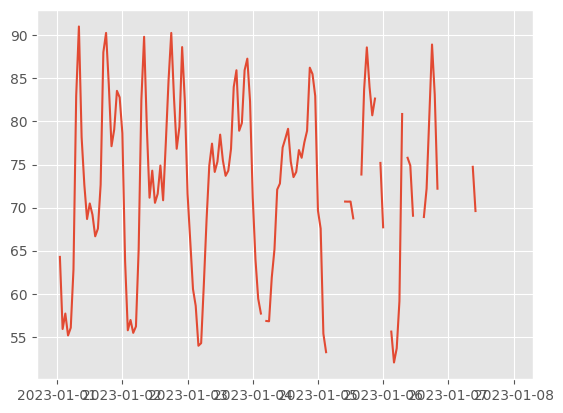

In [19]:
# plot the BS0_df Time and Energy
import matplotlib.pyplot as plt
plt.plot(BS0_df['Time'], BS0_df['Energy'])


In [20]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'BS0_df' is a pandas DataFrame with a 'Time' index and 'Energy' column
# Replace 'BS0_df' with your actual DataFrame

# Convert the 'Time' index to a DateTimeIndex (if it's not already)
BS0_df.index = pd.to_datetime(BS0_df.Time)

# Fit an ARIMA model
model = ARIMA(BS0_df['Energy'], order=(5, 1, 0))  # Example order: ARIMA(5,1,0)
model_fit = model.fit()

# Get a summary of the model
print(model_fit.summary())

# Make predictions
forecast = model_fit.forecast(steps=10)  # Change steps as needed for the number of predictions
print("Forecasted values:", forecast)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Energy   No. Observations:                  167
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -418.021
Date:                Mon, 30 Oct 2023   AIC                            848.043
Time:                        14:29:12   BIC                            866.715
Sample:                    01-01-2023   HQIC                           855.622
                         - 01-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4516      0.108      4.174      0.000       0.240       0.664
ar.L2         -0.2790      0.109     -2.560      0.010      -0.493      -0.065
ar.L3         -0.1594      0.134     -1.191      0.2

In [21]:
print(forecast.index)

DatetimeIndex(['2023-01-08 00:00:00', '2023-01-08 01:00:00',
               '2023-01-08 02:00:00', '2023-01-08 03:00:00',
               '2023-01-08 04:00:00', '2023-01-08 05:00:00',
               '2023-01-08 06:00:00', '2023-01-08 07:00:00',
               '2023-01-08 08:00:00', '2023-01-08 09:00:00'],
              dtype='datetime64[ns]', freq='H')


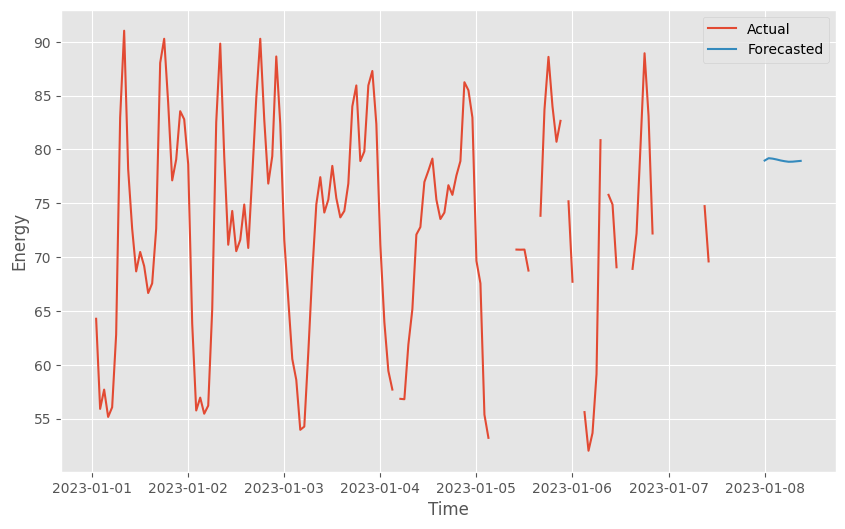

In [22]:
# plot the df with forecasted values in two different colors
plt.figure(figsize=(10, 6))
plt.plot(BS0_df['Time'], BS0_df['Energy'], label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecasted')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


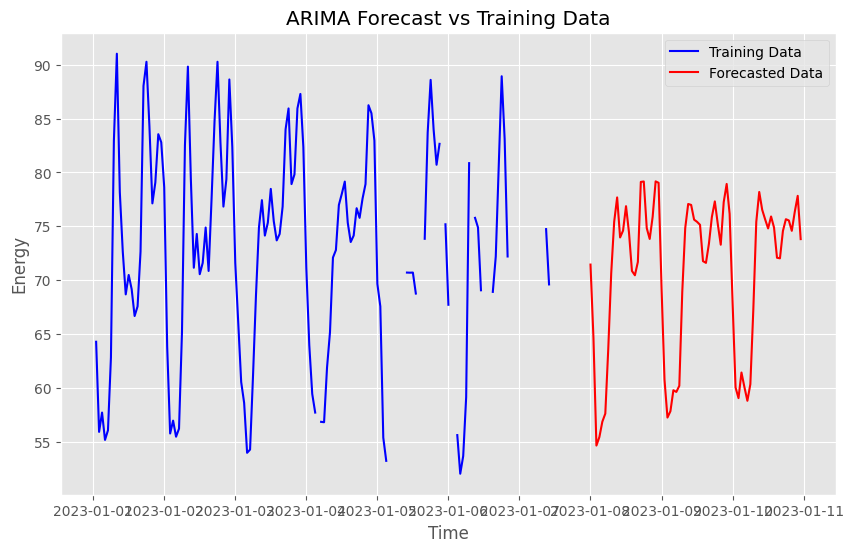

In [26]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming 'BS0_df' is your DataFrame with a 'Time' index and 'Energy' column
# Replace 'BS0_df' with your actual DataFrame

# Convert the 'Time' index to a DateTimeIndex (if it's not already)
BS0_df.index = pd.to_datetime(BS0_df.index)

# Fit an ARIMA model
model = ARIMA(BS0_df['Energy'], order=(24, 1, 12))  # Example order: ARIMA(5,1,0)
model_fit = model.fit()

# Define a new date range for forecasting
new_dates = pd.date_range(start='2023-01-08', periods=72, freq='H')  # Replace with your desired date range and frequency

# Get the forecasted values for the new date range
forecast = model_fit.forecast(steps=len(new_dates))

# Plotting
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(BS0_df.index, BS0_df['Energy'], color='blue', label='Training Data')

# Plot the forecasted values for the new date range
plt.plot(new_dates, forecast, color='red', label='Forecasted Data')

# Show the plot with legends
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('ARIMA Forecast vs Training Data')
plt.show()


In [30]:
BS0_df.tail(30)

,Time,BS,Energy
Time,,,
2023-01-06 18:00:00,2023-01-06 18:00:00,B_0,88.938715
2023-01-06 19:00:00,2023-01-06 19:00:00,B_0,83.109118
2023-01-06 20:00:00,2023-01-06 20:00:00,B_0,72.197309
2023-01-06 21:00:00,2023-01-06 21:00:00,NaN,NaN
2023-01-06 22:00:00,2023-01-06 22:00:00,B_0,72.534949
2023-01-06 23:00:00,2023-01-06 23:00:00,NaN,NaN
2023-01-07 00:00:00,2023-01-07 00:00:00,NaN,NaN
2023-01-07 01:00:00,2023-01-07 01:00:00,NaN,NaN
2023-01-07 02:00:00,2023-01-07 02:00:00,NaN,NaN


In [31]:
BS0_df.head()

,Time,BS,Energy
Time,,,
2023-01-01 01:00:00,2023-01-01 01:00:00,B_0,64.275037
2023-01-01 02:00:00,2023-01-01 02:00:00,B_0,55.904335
2023-01-01 03:00:00,2023-01-01 03:00:00,B_0,57.698057
2023-01-01 04:00:00,2023-01-01 04:00:00,B_0,55.156951
2023-01-01 05:00:00,2023-01-01 05:00:00,B_0,56.053812


In [32]:
BS0_df.head()

,Time,BS,Energy
Time,,,
2023-01-01 01:00:00,2023-01-01 01:00:00,B_0,64.275037
2023-01-01 02:00:00,2023-01-01 02:00:00,B_0,55.904335
2023-01-01 03:00:00,2023-01-01 03:00:00,B_0,57.698057
2023-01-01 04:00:00,2023-01-01 04:00:00,B_0,55.156951
2023-01-01 05:00:00,2023-01-01 05:00:00,B_0,56.053812


In [33]:
BS0_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167 entries, 2023-01-01 01:00:00 to 2023-01-07 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    167 non-null    datetime64[ns]
 1   BS      132 non-null    object        
 2   Energy  132 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.2+ KB


In [34]:
split_date1 = '2023-01-03 23:00:00'
split_date2 = '2023-01-04 12:00:00'

train_df = BS0_df[BS0_df['Time']<=pd.to_datetime(split_date1)]
test_df = BS0_df[(BS0_df['Time']<=pd.to_datetime(split_date2))&(BS0_df['Time']>pd.to_datetime(split_date1))]

In [35]:
test_df.head(12)

,Time,BS,Energy
Time,,,
2023-01-04 00:00:00,2023-01-04 00:00:00,B_0,71.150972
2023-01-04 01:00:00,2023-01-04 01:00:00,B_0,63.976084
2023-01-04 02:00:00,2023-01-04 02:00:00,B_0,59.431437
2023-01-04 03:00:00,2023-01-04 03:00:00,B_0,57.698057
2023-01-04 04:00:00,2023-01-04 04:00:00,NaN,NaN
2023-01-04 05:00:00,2023-01-04 05:00:00,B_0,56.837039
2023-01-04 06:00:00,2023-01-04 06:00:00,B_0,56.801196
2023-01-04 07:00:00,2023-01-04 07:00:00,B_0,61.883408
2023-01-04 08:00:00,2023-01-04 08:00:00,B_0,65.171898


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2023-01-01 01:00:00 to 2023-01-03 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    71 non-null     datetime64[ns]
 1   BS      71 non-null     object        
 2   Energy  71 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.2+ KB


In [37]:
MLFLOW_TRACKING_URI="https://dagshub.com/samithkavishke/5g-energy-consumption-modeling.mlflow"
MLFLOW_TRACKING_USERNAME="samithkavishke"
MLFLOW_TRACKING_PASSWORD="4469332900401a286a5aac72fc2664e61dbdd80b"


In [38]:
os.environ['MLFLOW_TRACKING_USERNAME'] = MLFLOW_TRACKING_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = MLFLOW_TRACKING_PASSWORD


In [39]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [40]:
import mlflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("TimeSeries")

<Experiment: artifact_location='mlflow-artifacts:/91ea91338e17458dbc119a68e4a43c23', creation_time=1698213974064, experiment_id='1', last_update_time=1698213974064, lifecycle_stage='active', name='TimeSeries', tags={}>

In [41]:
test_df.head(20)

,Time,BS,Energy
Time,,,
2023-01-04 00:00:00,2023-01-04 00:00:00,B_0,71.150972
2023-01-04 01:00:00,2023-01-04 01:00:00,B_0,63.976084
2023-01-04 02:00:00,2023-01-04 02:00:00,B_0,59.431437
2023-01-04 03:00:00,2023-01-04 03:00:00,B_0,57.698057
2023-01-04 04:00:00,2023-01-04 04:00:00,NaN,NaN
2023-01-04 05:00:00,2023-01-04 05:00:00,B_0,56.837039
2023-01-04 06:00:00,2023-01-04 06:00:00,B_0,56.801196
2023-01-04 07:00:00,2023-01-04 07:00:00,B_0,61.883408
2023-01-04 08:00:00,2023-01-04 08:00:00,B_0,65.171898


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 4.202043100901964
R2 Score: 0.6275328300671584
MAE: 2.9804339659996733


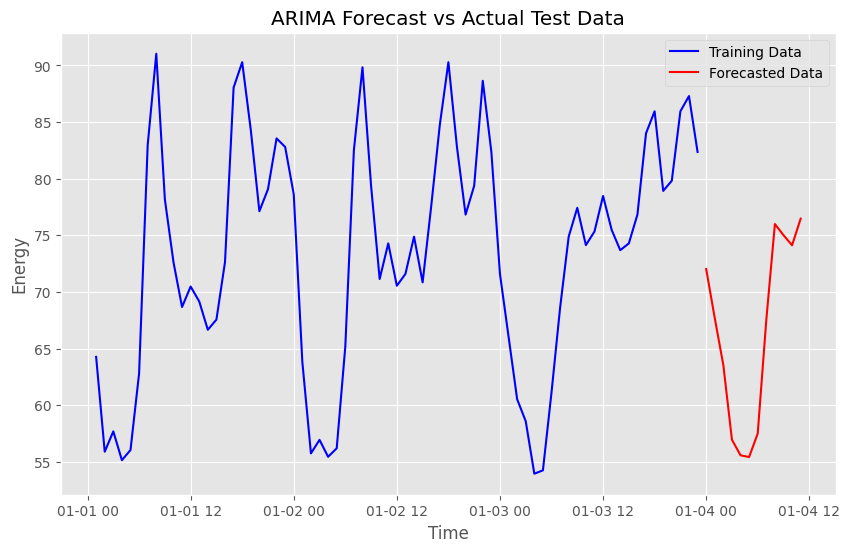

In [42]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming 'train_df' and 'test_df' are your DataFrames with 'Time' index and 'Energy' column
# Replace 'train_df' and 'test_df' with your actual DataFrames

# Convert the 'Time' index of test_df to a DateTimeIndex if it's not already


# Fit an ARIMA model using the train_df
model = ARIMA(train_df['Energy'], order=(24, 1, 0))  # Example order: ARIMA(24,1,0)
model_fit = model.fit()

# Get the forecasted values for the test_df dates
forecast = model_fit.forecast(steps=12)

# Create a new column 'Forecasted_Energy' in test_df and set the values as forecast
test_df['Forecasted_Energy'] = forecast

# Drop rows with NaN values in 'Energy' and 'Forecasted_Energy' columns in test_df
test_df.dropna(subset=['Energy', 'Forecasted_Energy'], inplace=True)

# Calculate RMSE, R2 score, and MAE after removing NaN values
rmse = mean_squared_error(test_df['Energy'], test_df['Forecasted_Energy'], squared=False)
r2 = r2_score(test_df['Energy'], test_df['Forecasted_Energy'])
mae = mean_absolute_error(test_df['Energy'], test_df['Forecasted_Energy'])

# Output the calculated metrics
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")
new_dates = pd.date_range(start='2023-01-04', periods=12, freq='H')  # Replace with your desired date range and frequency

plot_df = test_df.copy()
plot_df.index = pd.to_datetime(plot_df.Time)
plot_df.drop(columns="Time",axis=1,inplace=True)
plot_df.head(13)

plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train_df.Time, train_df['Energy'], color='blue', label='Training Data')

# Plot the forecasted values for the new date range
plt.plot(new_dates, forecast, color='red', label='Forecasted Data')

# Show the plot with legends
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('ARIMA Forecast vs Actual Test Data')
plt.show()

params = {'p':24,'d':12,'q': 0}
with mlflow.start_run():
  mlflow.log_params(params)
  # for key, value in params.items():
  #     mlflow.log_param(key, value)
  mlflow.log_metric("MAE", mae)
  mlflow.log_metric("RMSE", rmse)
  mlflow.log_metric("R2", r2)
  # mlflow.log_artifacts(model_fit)
  # mlflow.log_artifact('dataset_statistics.csv')
mlflow.end_run()

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2023-01-01 01:00:00 to 2023-01-03 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    71 non-null     datetime64[ns]
 1   BS      71 non-null     object        
 2   Energy  71 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.2+ KB


In [44]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming 'train_df' and 'test_df' are your DataFrames with 'Time' index and 'Energy' column
# Replace 'train_df' and 'test_df' with your actual DataFrames

# Convert the 'Time' index of test_df to a DateTimeIndex if it's not already

# Fit an ARIMA model using the train_df
model = ARIMA(train_df['Energy'], order=(24, 1, 0))  # Example order: ARIMA(24,1,0)
model_fit = model.fit()

# Get the forecasted values for the test_df dates
forecast = model_fit.forecast(steps=12)

# Create a new column 'Forecasted_Energy' in test_df and set the values as forecast
test_df['Forecasted_Energy'] = forecast

# Print the updated test_df with 'Forecasted_Energy' column
print(test_df)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                   Time   BS     Energy  Forecasted_Energy
Time                                                                      
2023-01-04 00:00:00 2023-01-04 00:00:00  B_0  71.150972          72.031140
2023-01-04 01:00:00 2023-01-04 01:00:00  B_0  63.976084          67.699664
2023-01-04 02:00:00 2023-01-04 02:00:00  B_0  59.431437          63.539513
2023-01-04 03:00:00 2023-01-04 03:00:00  B_0  57.698057          56.968458
2023-01-04 05:00:00 2023-01-04 05:00:00  B_0  56.837039          55.435222
2023-01-04 06:00:00 2023-01-04 06:00:00  B_0  56.801196          57.509181
2023-01-04 07:00:00 2023-01-04 07:00:00  B_0  61.883408          67.535104
2023-01-04 08:00:00 2023-01-04 08:00:00  B_0  65.171898          75.998826
2023-01-04 09:00:00 2023-01-04 09:00:00  B_0  72.096615          75.016286
2023-01-04 10:00:00 2023-01-04 10:00:00  B_0  72.795217          74.126104
2023-01-04 11:00:00 2023-01-04 11:00:00  B_0  76.980568          76.476201


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


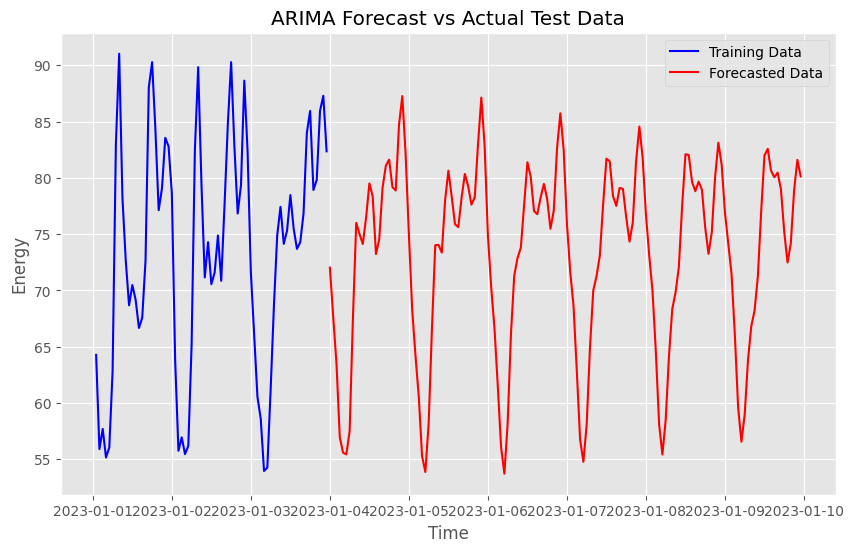

In [46]:
new_dates = pd.date_range(start='2023-01-04', periods=144, freq='H')  # Replace with your desired date range and frequency
forecast = model_fit.forecast(steps=144)
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train_df.index, train_df['Energy'], color='blue', label='Training Data')

# Plot the forecasted values for the new date range
plt.plot(new_dates, forecast, color='red', label='Forecasted Data')

# Show the plot with legends
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('ARIMA Forecast vs Actual Test Data')
plt.show()


In [50]:
# create a dataframe with Time and mean energy with grouping the basestaions
import pandas as pd

general_df = concat_df.groupby('Time')['Energy'].mean().reset_index()
general_df.head()

,Time,Energy
0,2023-01-01 01:00:00,24.357312
1,2023-01-01 02:00:00,22.866683
2,2023-01-01 03:00:00,21.999350
3,2023-01-01 04:00:00,21.591313
4,2023-01-01 05:00:00,21.476990


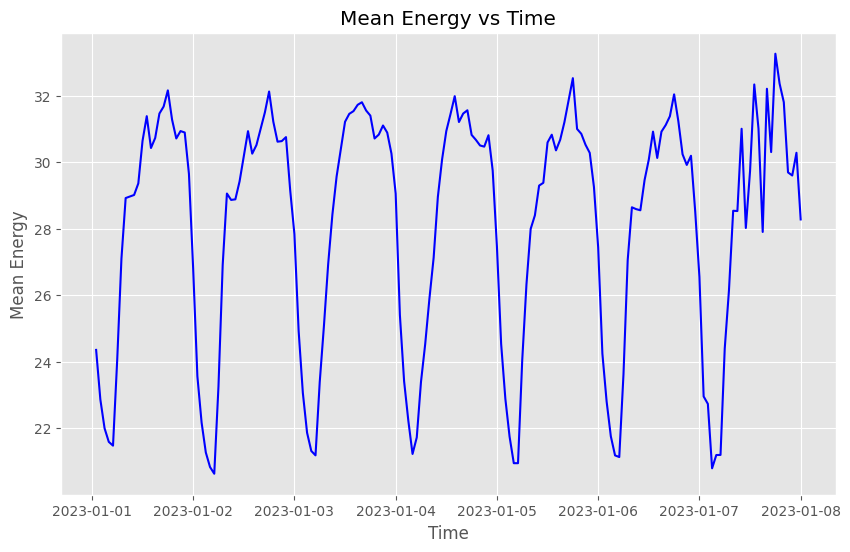

In [49]:
# plot the df_grouped data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(general_df['Time'], general_df['Energy'], color='blue')
plt.xlabel('Time')
plt.ylabel('Mean Energy')
plt.title('Mean Energy vs Time')
plt.show()


In [67]:
general_df['Time'] = pd.to_datetime(general_df['Time'])
# reset index to
general_df = general_df.set_index('Time')
general_df.head()

,Energy
Time,
2023-01-01 01:00:00,24.357312
2023-01-01 02:00:00,22.866683
2023-01-01 03:00:00,21.999350
2023-01-01 04:00:00,21.591313
2023-01-01 05:00:00,21.476990


In [69]:
general_split1,general_split2 = '2023-01-05 23:00:00','2023-01-07 23:00:00'
general_test = general_df[(general_df.index<=pd.to_datetime(general_split2))&(general_df.index>pd.to_datetime(general_split1))]
general_train = general_df[(general_df.index<=pd.to_datetime(general_split1))]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.9425681042451857
R2 Score: 0.9330580895959603
MAE: 0.6442943469835557


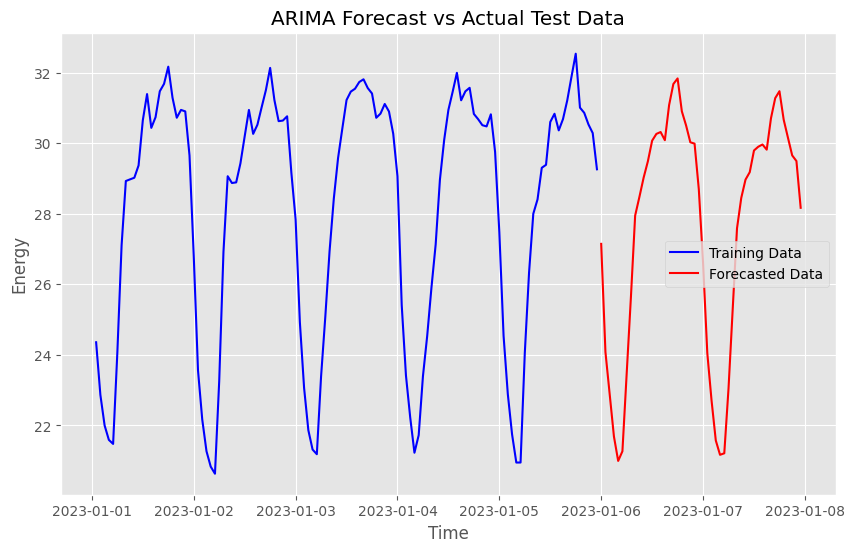

In [83]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming 'general_train' and 'general_test' are your DataFrames with 'Time' index and 'Energy' column
# Replace 'general_train' and 'test_df' with your actual DataFrames

# Convert the 'Time' index of test_df to a DateTimeIndex if it's not already
params = {"p":24,"d":2,"q":0}
# Fit an ARIMA model using the general_train
model = ARIMA(general_train['Energy'], order=tuple(params.values()))  # Example order: ARIMA(24,1,0)
model_fit = model.fit()

# Get the forecasted values for the test_df dates
general_forecast = model_fit.forecast(steps=48)
new_dates = pd.date_range(start='2023-01-06', periods=48, freq='H')  # Replace with your desired date range and frequency

# Create a new column 'Forecasted_Energy' in test_df and set the values as forecast
general_test['Forecasted_Energy'] = general_forecast

# Print the updated test_df with 'Forecasted_Energy' column
# print(test_df)

# Drop rows with NaN values in 'Energy' and 'Forecasted_Energy' columns in test_df
general_test.dropna(subset=['Energy', 'Forecasted_Energy'], inplace=True)

# Calculate RMSE, R2 score, and MAE after removing NaN values
rmse = mean_squared_error(general_test['Energy'], general_test['Forecasted_Energy'], squared=False)
r2 = r2_score(general_test['Energy'], general_test['Forecasted_Energy'])
mae = mean_absolute_error(general_test['Energy'], general_test['Forecasted_Energy'])

# Output the calculated metrics
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")
new_dates = pd.date_range(start='2023-01-06', periods=48, freq='H')  # Replace with your desired date range and frequency

# plot_df = general_test.copy()
# plot_df.index = pd.to_datetime(plot_df.index)
# plot_df.drop(columns="Time",axis=1,inplace=True)
# plot_df.head(13)

plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(general_train.index, general_train['Energy'], color='blue', label='Training Data')

# Plot the forecasted values for the new date range
plt.plot(new_dates, general_forecast, color='red', label='Forecasted Data')

# Show the plot with legends
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('ARIMA Forecast vs Actual Test Data')
plt.show()

with mlflow.start_run():
  mlflow.log_params(params)
  # for key, value in params.items():
  #     mlflow.log_param(key, value)
  mlflow.log_metric("MAE", mae)
  mlflow.log_metric("RMSE", rmse)
  mlflow.log_metric("R2", r2)
  # mlflow.log_artifacts(model_fit)
  # mlflow.log_artifact('dataset_statistics.csv')
mlflow.end_run()



In [81]:
tuple(params.values())

(24, 1, 0)